# **Transformer Module of WorldQuant University Capstone for MScFE 690 (Group 9184)**

## Creating features for RL Agents from Transformer Models.


<br>

|**DynaCAAST framework for RL based trading agents**| |
|:---|:---|
|**TEAM MEMBER 1** | Farai Masunda  |
|**TEAM MEMBER 2**  |      Bhaskar Vedula  |


<hr style='border:4px solid black'>

## **Section 1: Python imports**

Here we import all libraries that we require for creating features from our Transformer Model.

In [ ]:
import math
import numpy as np
from numpy import array
import pandas as pd
import datetime
import os
import time
from time import time
import copy
import random
from random import sample
from tabulate import tabulate
import typing as tt
from collections import namedtuple, deque
from itertools import count

from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, GlobalAveragePooling1D

import pathlib
from pathlib import Path
import pandas_datareader.data as web

import matplotlib.pylab as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection
from matplotlib.colors import Colormap, ListedColormap, BoundaryNorm
%matplotlib inline

import seaborn as sns
from IPython.display import display, HTML

import yfinance as yf

<hr style='border:2px solid black'>

## **Section 2: Defining functions**

The below functions are defined to create data in a format that can be processed by our Transformer Module. We also create ancilliary function for training our model.

In [ ]:
def getData (data, step=1):
    dataX, dataY = [], []
    for i in range(len(data) - step - 1):
        a = data[i:(i + step), 0]
        dataX.append(a)
        dataY.append(data[i + step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
# Transformer Encoder Segment
def tx_block(inputs, size, heads, ffDim, dropout=0):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=size, num_heads=heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ffDim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

<hr style='border:2px solid black'>

## **Section 3: Defining start date and end date and tickers**


In [ ]:
# We define the time period for our analysis here. The start date and end date used for this purpose is shown below.
# Note that this period will encompass both in the sample and out of the sample data and as this is a time series data we will split the
# time horizon into in the sample, out of the sample and validation.
# time format = '%Y-%m-%d'

START_DATE =  '2006-01-01'
END_DATE   =  '2009-12-31'

In [ ]:
tickers = ['BHARTIARTL.NS',  'NTPC.NS',     'MARUTI.NS', 'NESTLEIND.NS', 'BAJFINANCE.NS', 'KOTAKBANK.NS',  'TATASTEEL.NS',  'ONGC.NS',       'BAJAJ-AUTO.NS', 'LT.NS',           'ITC.NS',   'TCS.NS',     'BRITANNIA.NS',
           'SHRIRAMFIN.NS',  'ADANIENT.NS', 'CIPLA.NS',  'WIPRO.NS',     'INDUSINDBK.NS', 'ULTRACEMCO.NS', 'TATACONSUM.NS', 'BAJAJFINSV.NS', 'RELIANCE.NS',   'HEROMOTOCO.NS',   'TITAN.NS', 'HINDALCO.NS','APOLLOHOSP.NS']

<hr style='border:2px solid black'>

## **Section 4: Training of our Transformer Model**


In this section, we train our Transformer Model with the training data that we have created below.

In [ ]:
testPredictPlot_list = []
trainPredictPlot_list = []
data_scaled_list = []
all_data = []
iter = 0
modelSummary = 0

for ticker in tickers:
  # Load and prepare the dataset
  df = yf.download(ticker,  start=START_DATE, end=END_DATE)
  df.bfill(inplace=True)
  data = df[['Close']].values
  scaler = MinMaxScaler(feature_range=(0, 1))
  data_scaled = scaler.fit_transform(data)

  # Parameters
  step = 30
  training_size = int(len(data_scaled) * 0.75)
  test_size = len(data_scaled) - training_size
  train_data, test_data = data_scaled[0:training_size,:], data_scaled[training_size:len(data_scaled),:]

  X_train, y_train = getData(train_data, step)
  X_test, y_test = getData(test_data, step)
  X_all = np.concatenate([data_scaled[:step], data_scaled[:], data_scaled[-1:] ])
  X_all, y_all   = getData(X_all, step)

  # Reshape input for the model
  X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
  X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
  X_all = X_all.reshape(X_all.shape[0], X_all.shape[1], 1)

  # Model Definition
  inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
  x = tx_block(inputs, size=256, heads=4, ffDim=4, dropout=0.1)
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(20, activation="relu")(x)
  outputs = Dense(1, activation="linear")(x)

  model = Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer="adam", loss="mean_squared_error")

  if iter == 0:
    modelSummary = model
    iter = 1

  # We training the model here
  model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, verbose=0)

  # These are predictions used for state for our RL agents
  train_predict = model.predict(X_train)
  test_predict = model.predict(X_test)
  all_predict = model.predict(X_all)

  # Perform inverse transformation of the predictions
  train_predict = scaler.inverse_transform(train_predict)
  test_predict = scaler.inverse_transform(test_predict)
  all_predict = scaler.inverse_transform(all_predict)
  all_data.append(all_predict)

  # Preparing for plotting the results later
  trainPredictPlot = np.empty_like(data_scaled)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[step:len(train_predict)+step, :] = train_predict
  trainPredictPlot_list.append(trainPredictPlot)

  # Adjust the data to account for steps
  testPredictPlot = np.empty_like(data_scaled)
  testPredictPlot[:, :] = np.nan
  testPredictPlot[len(train_predict)+(step*2)+1:len(data_scaled)-1, :] = test_predict
  testPredictPlot_list.append(testPredictPlot)

  data_scaled_list.append(scaler.inverse_transform(data_scaled))


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[*********************100%***********************]  1 of 1 completed


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[*********************100%***********************]  1 of 1 completed


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[*********************100%***********************]  1 of 1 completed


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[*********************100%***********************]  1 of 1 completed


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[*********************100%***********************]  1 of 1 completed


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[*********************100%***********************]  1 of 1 completed


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[*********************100%***********************]  1 of 1 completed


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[*********************100%***********************]  1 of 1 completed


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[*********************100%***********************]  1 of 1 completed


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[*********************100%***********************]  1 of 1 completed


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[*********************100%***********************]  1 of 1 completed


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[*********************100%***********************]  1 of 1 completed


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[*********************100%***********************]  1 of 1 completed


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[*********************100%***********************]  1 of 1 completed


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[*********************100%***********************]  1 of 1 completed


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[*********************100%***********************]  1 of 1 completed


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[*********************100%***********************]  1 of 1 completed


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[*********************100%***********************]  1 of 1 completed


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[*********************100%***********************]  1 of 1 completed


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[*********************100%***********************]  1 of 1 completed


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[*********************100%***********************]  1 of 1 completed


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[*********************100%***********************]  1 of 1 completed


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[*********************100%***********************]  1 of 1 completed


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[*********************100%***********************]  1 of 1 completed


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[*********************100%***********************]  1 of 1 completed


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


We look at the configuration of the model below

In [ ]:
modelSummary.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 30, 1)     │          2 │ input_layer[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 1)     │      7,169 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 30, 1)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 30, 1)     │          0 │ dropout_1[0][0],  │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 1)     │          2 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 30, 4)     │          8 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 30, 4)     │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 30, 1)     │          5 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 30, 1)     │          0 │ dense_1[0][0],    │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 30)        │          0 │ add_1[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 30)        │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 20)        │        620 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         21 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,483 (91.73 KB)

 Trainable params: 7,827 (30.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 15,656 (61.16 KB)

<hr style='border:2px solid black'>

## **Section 5: Evaluating our Transformer Model**



We check performance of our Transformer Model output to validate its role as a state for our RL agents**

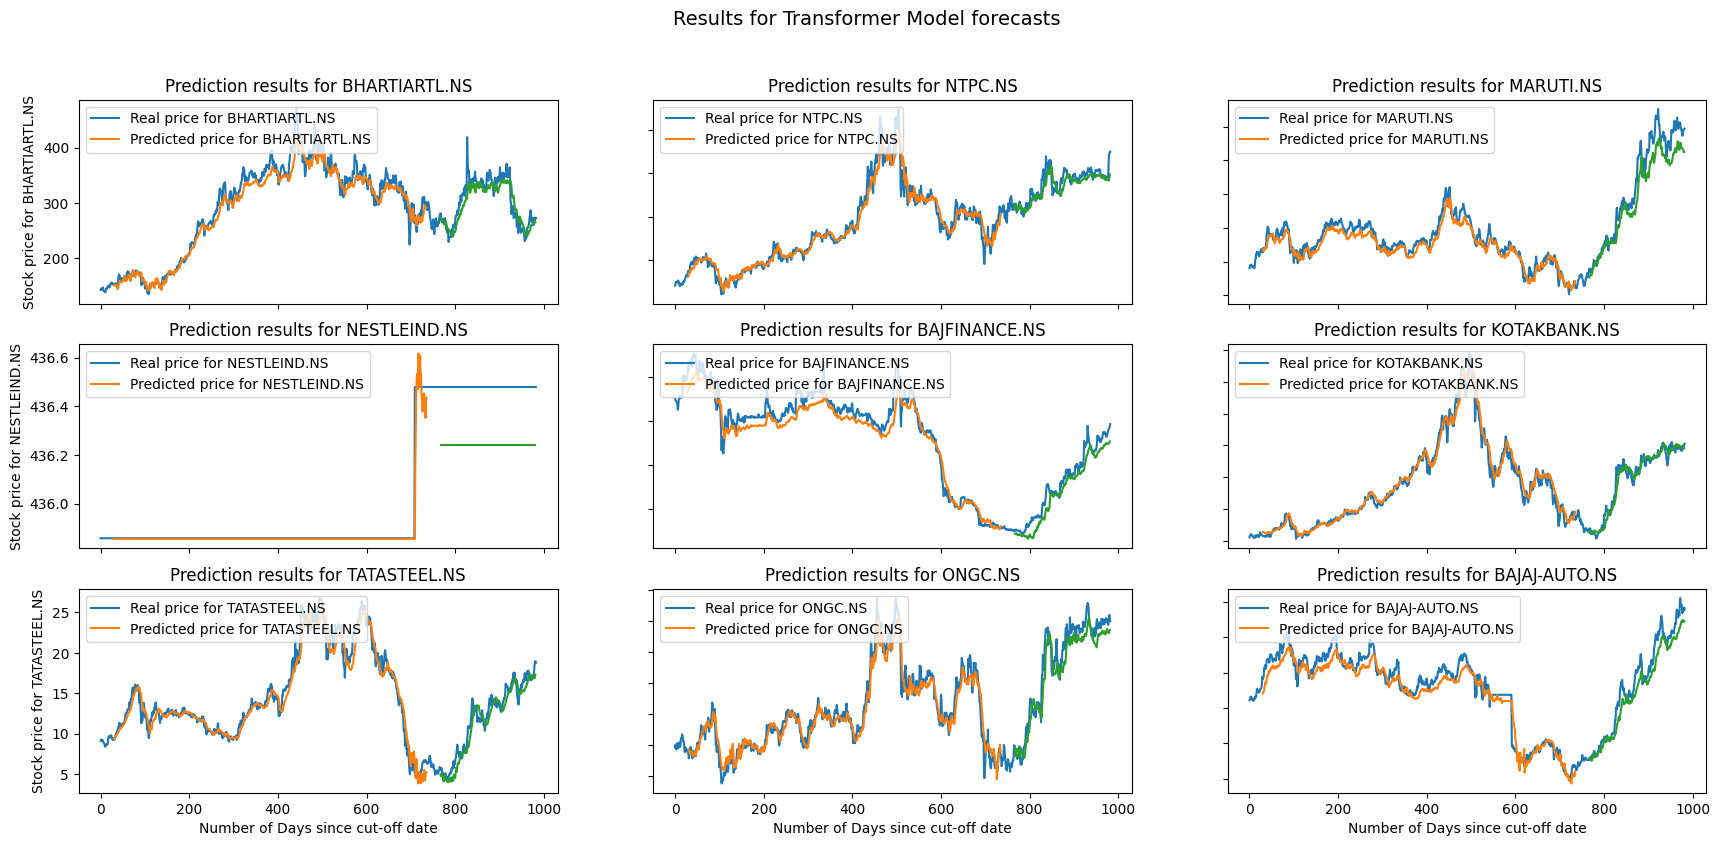

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(21, 9))
plt.suptitle("Results for Transformer Model forecasts", fontsize=14)

axs[0, 0].plot(data_scaled_list[0], label='Actual Stock Price')
axs[0, 0].plot(trainPredictPlot_list[0], label='Train Predict')
axs[0, 0].plot(testPredictPlot_list[0], label='Test Predict')
axs[0, 0].set_title("Prediction results for "+ tickers[0])
axs[0, 0].legend()

axs[0, 1].plot(data_scaled_list[1], label='Actual Stock Price')
axs[0, 1].plot(trainPredictPlot_list[1], label='Train Predict')
axs[0, 1].plot(testPredictPlot_list[1], label='Test Predict')
axs[0, 1].set_title("Prediction results for "+ tickers[1])
axs[0, 1].legend()

axs[0, 2].plot(data_scaled_list[2], label='Actual Stock Price')
axs[0, 2].plot(trainPredictPlot_list[2], label='Train Predict')
axs[0, 2].plot(testPredictPlot_list[2], label='Test Predict')
axs[0, 2].set_title("Prediction results for "+ tickers[2])
axs[0, 2].legend()


axs[1, 0].plot(data_scaled_list[3], label='Actual Stock Price')
axs[1, 0].plot(trainPredictPlot_list[3], label='Train Predict')
axs[1, 0].plot(testPredictPlot_list[3], label='Test Predict')
axs[1, 0].set_title("Prediction results for "+ tickers[3])
axs[1, 0].legend()


axs[1, 1].plot(data_scaled_list[4], label='Actual Stock Price')
axs[1, 1].plot(trainPredictPlot_list[4], label='Train Predict')
axs[1, 1].plot(testPredictPlot_list[4], label='Test Predict')
axs[1, 1].set_title("Prediction results for "+ tickers[4])
axs[1, 1].legend()


axs[1, 2].plot(data_scaled_list[5], label='Actual Stock Price')
axs[1, 2].plot(trainPredictPlot_list[5], label='Train Predict')
axs[1, 2].plot(testPredictPlot_list[5], label='Test Predict')
axs[1, 2].set_title("Prediction results for "+ tickers[5])
axs[1, 2].legend()

axs[2, 0].plot(data_scaled_list[6], label='Actual Stock Price')
axs[2, 0].plot(trainPredictPlot_list[6], label='Train Predict')
axs[2, 0].plot(testPredictPlot_list[6], label='Test Predict')
axs[2, 0].set_title("Prediction results for "+ tickers[6])
axs[2, 0].legend()

axs[2, 1].plot(data_scaled_list[7], label='Actual Stock Price')
axs[2, 1].plot(trainPredictPlot_list[7], label='Train Predict')
axs[2, 1].plot(testPredictPlot_list[7], label='Test Predict')
axs[2, 1].set_title("Prediction results for "+ tickers[7])
axs[2, 1].legend()

axs[2, 2].plot(data_scaled_list[8], label='Actual Stock Price')
axs[2, 2].plot(trainPredictPlot_list[8], label='Train Predict')
axs[2, 2].plot(testPredictPlot_list[8], label='Test Predict')
axs[2, 2].set_title("Prediction results for "+ tickers[8])
axs[2, 2].legend()

for ax, tick in zip(axs.flat, tickers):
    ax.set(xlabel = "Number of Days since cut-off date", ylabel = "Stock price for " + tick)
    ax.legend(("Real price for "+ tick, "Predicted price for "+ tick), loc="upper left")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

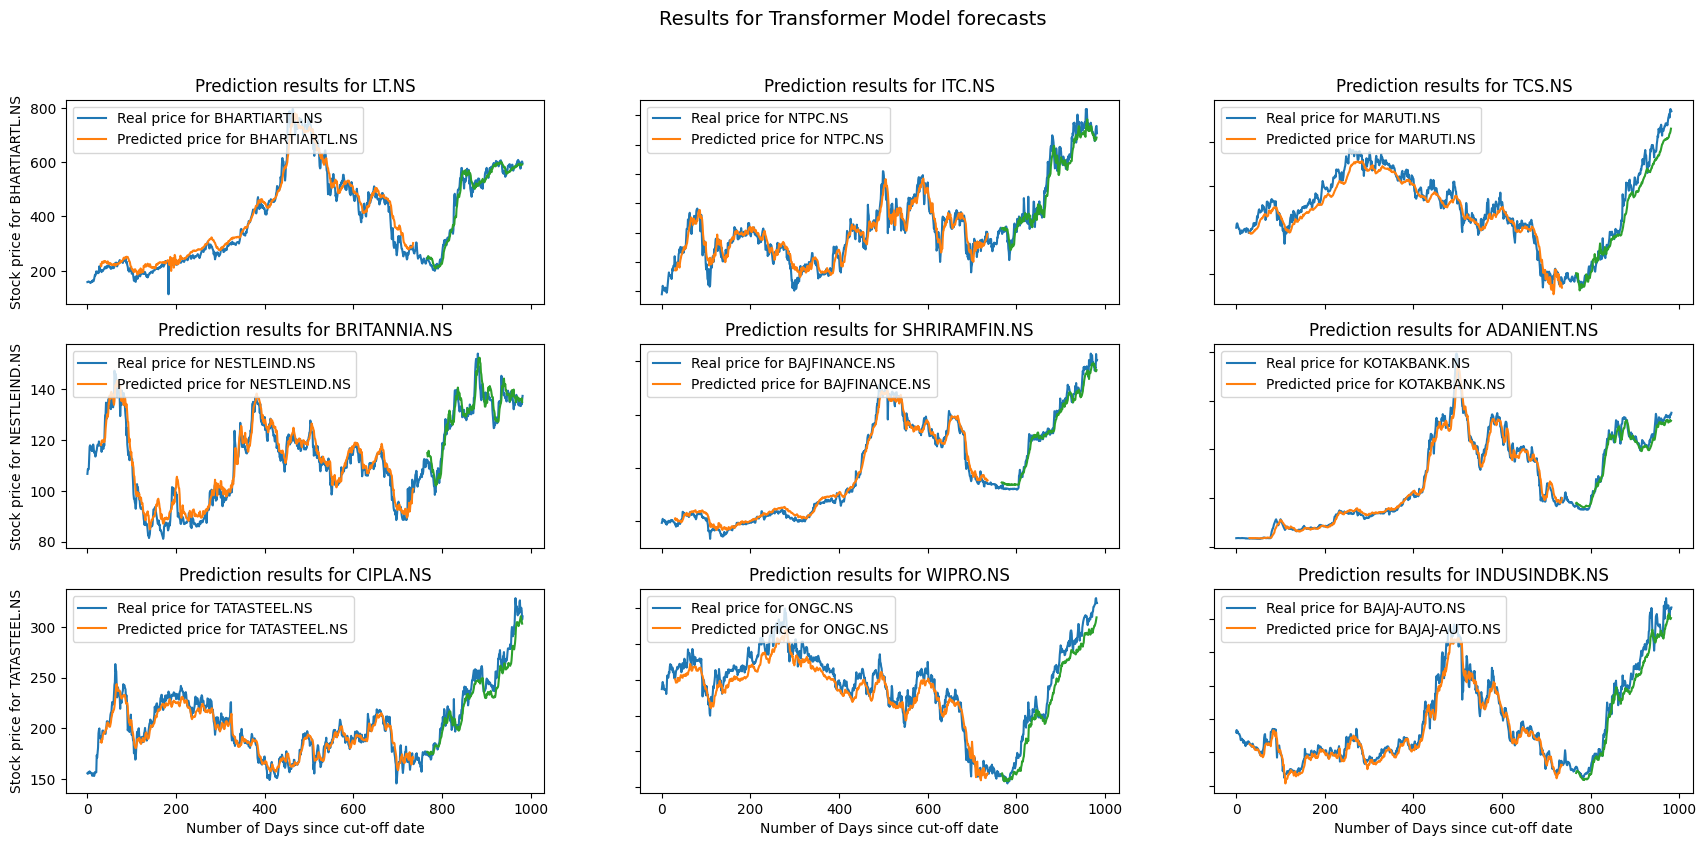

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(21, 9))
plt.suptitle("Results for Transformer Model forecasts", fontsize=14)

axs[0, 0].plot(data_scaled_list[9], label='Actual Stock Price')
axs[0, 0].plot(trainPredictPlot_list[9], label='Train Predict')
axs[0, 0].plot(testPredictPlot_list[9], label='Test Predict')
axs[0, 0].set_title("Prediction results for "+ tickers[9])
axs[0, 0].legend()

axs[0, 1].plot(data_scaled_list[10], label='Actual Stock Price')
axs[0, 1].plot(trainPredictPlot_list[10], label='Train Predict')
axs[0, 1].plot(testPredictPlot_list[10], label='Test Predict')
axs[0, 1].set_title("Prediction results for "+ tickers[10])
axs[0, 1].legend()

axs[0, 2].plot(data_scaled_list[11], label='Actual Stock Price')
axs[0, 2].plot(trainPredictPlot_list[11], label='Train Predict')
axs[0, 2].plot(testPredictPlot_list[11], label='Test Predict')
axs[0, 2].set_title("Prediction results for "+ tickers[11])
axs[0, 2].legend()


axs[1, 0].plot(data_scaled_list[12], label='Actual Stock Price')
axs[1, 0].plot(trainPredictPlot_list[12], label='Train Predict')
axs[1, 0].plot(testPredictPlot_list[12], label='Test Predict')
axs[1, 0].set_title("Prediction results for "+ tickers[12])
axs[1, 0].legend()


axs[1, 1].plot(data_scaled_list[13], label='Actual Stock Price')
axs[1, 1].plot(trainPredictPlot_list[13], label='Train Predict')
axs[1, 1].plot(testPredictPlot_list[13], label='Test Predict')
axs[1, 1].set_title("Prediction results for "+ tickers[13])
axs[1, 1].legend()


axs[1, 2].plot(data_scaled_list[14], label='Actual Stock Price')
axs[1, 2].plot(trainPredictPlot_list[14], label='Train Predict')
axs[1, 2].plot(testPredictPlot_list[14], label='Test Predict')
axs[1, 2].set_title("Prediction results for "+ tickers[14])
axs[1, 2].legend()

axs[2, 0].plot(data_scaled_list[15], label='Actual Stock Price')
axs[2, 0].plot(trainPredictPlot_list[15], label='Train Predict')
axs[2, 0].plot(testPredictPlot_list[15], label='Test Predict')
axs[2, 0].set_title("Prediction results for "+ tickers[15])
axs[2, 0].legend()

axs[2, 1].plot(data_scaled_list[16], label='Actual Stock Price')
axs[2, 1].plot(trainPredictPlot_list[16], label='Train Predict')
axs[2, 1].plot(testPredictPlot_list[16], label='Test Predict')
axs[2, 1].set_title("Prediction results for "+ tickers[16])
axs[2, 1].legend()

axs[2, 2].plot(data_scaled_list[17], label='Actual Stock Price')
axs[2, 2].plot(trainPredictPlot_list[17], label='Train Predict')
axs[2, 2].plot(testPredictPlot_list[17], label='Test Predict')
axs[2, 2].set_title("Prediction results for "+ tickers[17])
axs[2, 2].legend()

for ax, tick in zip(axs.flat, tickers):
    ax.set(xlabel = "Number of Days since cut-off date", ylabel = "Stock price for " + tick)
    ax.legend(("Real price for "+ tick, "Predicted price for "+ tick), loc="upper left")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

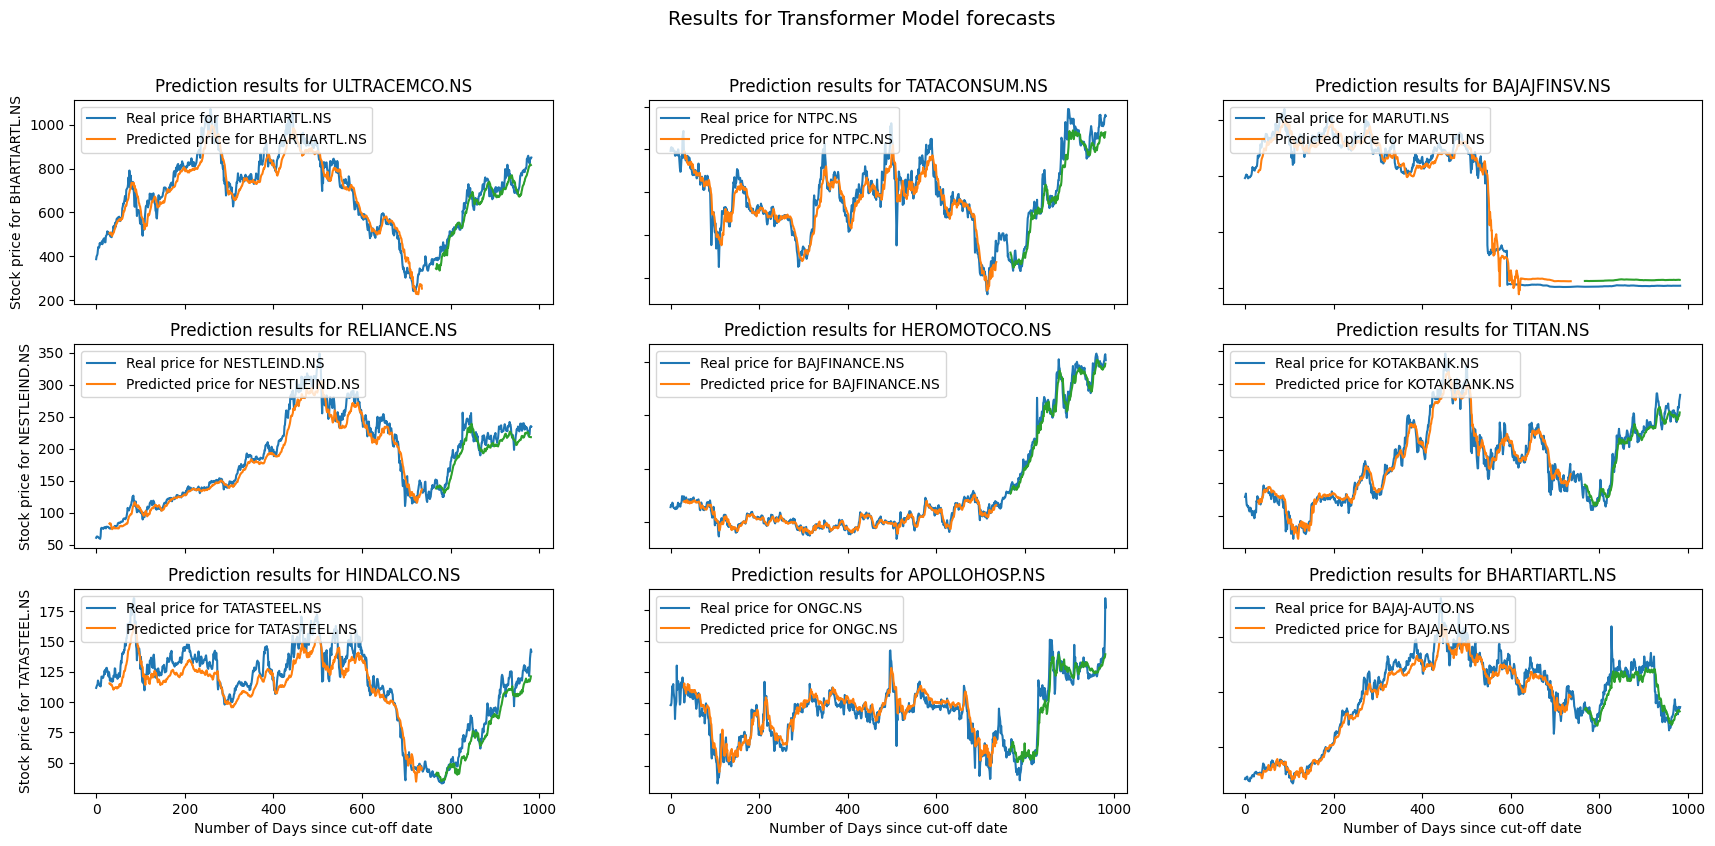

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(21, 9))
plt.suptitle("Results for Transformer Model forecasts", fontsize=14)

axs[0, 0].plot(data_scaled_list[18], label='Actual Stock Price')
axs[0, 0].plot(trainPredictPlot_list[18], label='Train Predict')
axs[0, 0].plot(testPredictPlot_list[18], label='Test Predict')
axs[0, 0].set_title("Prediction results for "+ tickers[18])
axs[0, 0].legend()

axs[0, 1].plot(data_scaled_list[19], label='Actual Stock Price')
axs[0, 1].plot(trainPredictPlot_list[19], label='Train Predict')
axs[0, 1].plot(testPredictPlot_list[19], label='Test Predict')
axs[0, 1].set_title("Prediction results for "+ tickers[19])
axs[0, 1].legend()

axs[0, 2].plot(data_scaled_list[20], label='Actual Stock Price')
axs[0, 2].plot(trainPredictPlot_list[20], label='Train Predict')
axs[0, 2].plot(testPredictPlot_list[20], label='Test Predict')
axs[0, 2].set_title("Prediction results for "+ tickers[20])
axs[0, 2].legend()


axs[1, 0].plot(data_scaled_list[21], label='Actual Stock Price')
axs[1, 0].plot(trainPredictPlot_list[21], label='Train Predict')
axs[1, 0].plot(testPredictPlot_list[21], label='Test Predict')
axs[1, 0].set_title("Prediction results for "+ tickers[21])
axs[1, 0].legend()


axs[1, 1].plot(data_scaled_list[22], label='Actual Stock Price')
axs[1, 1].plot(trainPredictPlot_list[22], label='Train Predict')
axs[1, 1].plot(testPredictPlot_list[22], label='Test Predict')
axs[1, 1].set_title("Prediction results for "+ tickers[22])
axs[1, 1].legend()


axs[1, 2].plot(data_scaled_list[23], label='Actual Stock Price')
axs[1, 2].plot(trainPredictPlot_list[23], label='Train Predict')
axs[1, 2].plot(testPredictPlot_list[23], label='Test Predict')
axs[1, 2].set_title("Prediction results for "+ tickers[23])
axs[1, 2].legend()

axs[2, 0].plot(data_scaled_list[24], label='Actual Stock Price')
axs[2, 0].plot(trainPredictPlot_list[24], label='Train Predict')
axs[2, 0].plot(testPredictPlot_list[24], label='Test Predict')
axs[2, 0].set_title("Prediction results for "+ tickers[24])
axs[2, 0].legend()

axs[2, 1].plot(data_scaled_list[25], label='Actual Stock Price')
axs[2, 1].plot(trainPredictPlot_list[25], label='Train Predict')
axs[2, 1].plot(testPredictPlot_list[25], label='Test Predict')
axs[2, 1].set_title("Prediction results for "+ tickers[25])
axs[2, 1].legend()

axs[2, 2].plot(data_scaled_list[0], label='Actual Stock Price')
axs[2, 2].plot(trainPredictPlot_list[0], label='Train Predict')
axs[2, 2].plot(testPredictPlot_list[0], label='Test Predict')
axs[2, 2].set_title("Prediction results for "+ tickers[0])
axs[2, 2].legend()

for ax, tick in zip(axs.flat, tickers):
    ax.set(xlabel = "Number of Days since cut-off date", ylabel = "Stock price for " + tick)
    ax.legend(("Real price for "+ tick, "Predicted price for "+ tick), loc="upper left")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

<hr style='border:2px solid black'>

## **Section 6: Data for state representing Transformer forecasts**

We now create data for states representing predictions from our Transformer model. For we first create training data to train a Transformer model and then use this model to spew out our 'state' representation. We carry out this exercise in a this notebook as the training requires TPU. This output is then provided to our main notebook to train RL agents based on this state.

In [ ]:
TransformerFeaturesDF = pd.DataFrame()

for i, tick in enumerate(tickers):
  if len(all_data[i]) > 1232:
    TransformerFeaturesDF[tick] = np.squeeze(all_data[i][1:])
  else:
    TransformerFeaturesDF[tick] = np.squeeze(all_data[i])

In [ ]:
TransformerFeaturesDF.to_csv("TransformerFeaturesDF_Stress")